# Bicycle trajectory forecasting in Bologna

## 3 - Deep Neural Network classifier

We try to improve the prediction accuracy by rephrasing the problem as a classification. We treat the direction of the final movement in the trajectory as a label and try to predict it from the previous points in the trajectory.

This way we expect accuracy to be higher since the network does not need to learn that the next location is always one of the eight adjacent to the previous one. Moreover, we preserve the natural discreteness of the prediction in the original problem.

In [1]:
import pandas as pd
import numpy as np

data            = pd.read_csv("../../preproc/may_jump_encoded_bike.csv", header = None).to_numpy()
indep_test_data = pd.read_csv("../../preproc/june_jump_encoded_bike.csv", header = None).to_numpy()

read = 5

X = np.concatenate([data[:,11-read:11], data[:,-1-read:-1]], axis = 1)
X = X.reshape((X.shape[0], -1, X.shape[1] // 2)).swapaxes(1,2)
Y = data[:,-1:]

X_it = np.concatenate([indep_test_data[:,11-read:11], indep_test_data[:,-1-read:-1]], axis = 1)
X_it = X_it.reshape((X_it.shape[0], -1, X_it.shape[1] // 2)).swapaxes(1,2)
Y_it = indep_test_data[:,-1:]

In [2]:
X.shape, X_it.shape

((512882, 5, 2), (382732, 5, 2))

In [10]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import tensorflow as tf

seed_value = 1789

np.random.seed(seed_value)
tf.random.set_seed(seed_value)

model = keras.Sequential()
model.add(layers.Input  (shape=(read, 2)))
model.add(layers.Flatten())
model.add(layers.Dense  ( 64, kernel_initializer = "glorot_normal", activation='relu'))
model.add(layers.Dense  (128, kernel_initializer = "glorot_normal", activation='relu'))
model.add(layers.Dropout(rate = .025))
model.add(layers.Dense  ( 64, kernel_initializer = "glorot_normal", activation='relu'))
model.add(layers.Dense  ( 32, kernel_initializer = "glorot_normal", activation='relu'))
model.add(layers.Dense  ( 16, kernel_initializer = "glorot_normal", activation='relu'))
model.add(layers.Dense  (  8, kernel_initializer = "glorot_normal"))
model.add(layers.Softmax())

loss_function = 'SparseCategoricalCrossentropy'
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss=loss_function, optimizer=adam, metrics=['SparseCategoricalCrossentropy', 'SparseCategoricalAccuracy'])

We define a DNN with a total of seven hidden layers, one of which is a dropout layer, while the remainder are all densely connected layers. Exploring several configuration we have found a good balance by setting the layer dimension as detailed below.

We select `SparseCategoricalCrossentropy` as loss function since we are dealing with a classification task and we wish to use numerically encoded labels.

The dropout has been added to help with generalisation, the rate being selected after some attempts as well, balancing overall accuracy and the reduction of the gap between the training and test loss.

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)               

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.70)

We train the model on the may dataset, for 600 epochs.

In [13]:
history = model.fit(X_train, Y_train, epochs= 600,batch_size=1024, validation_data=(X_test, Y_test))

Epoch 1/600
351/351 [==============================] - 1s 2ms/step - loss: 1.3968 - sparse_categorical_crossentropy: 1.3968 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.1963 - val_sparse_categorical_crossentropy: 1.1963 - val_sparse_categorical_accuracy: 0.5366
Epoch 2/600
351/351 [==============================] - 1s 2ms/step - loss: 1.1941 - sparse_categorical_crossentropy: 1.1941 - sparse_categorical_accuracy: 0.5373 - val_loss: 1.1580 - val_sparse_categorical_crossentropy: 1.1580 - val_sparse_categorical_accuracy: 0.5583
Epoch 3/600
351/351 [==============================] - 1s 2ms/step - loss: 1.1581 - sparse_categorical_crossentropy: 1.1581 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1357 - val_sparse_categorical_crossentropy: 1.1357 - val_sparse_categorical_accuracy: 0.5711
Epoch 4/600
351/351 [==============================] - 1s 2ms/step - loss: 1.1253 - sparse_categorical_crossentropy: 1.1253 - sparse_categorical_accuracy: 0.5773 - val_loss: 1.1010 - val_sparse

351/351 [==============================] - 1s 2ms/step - loss: 0.9575 - sparse_categorical_crossentropy: 0.9575 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.9571 - val_sparse_categorical_crossentropy: 0.9571 - val_sparse_categorical_accuracy: 0.6564
Epoch 32/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9555 - sparse_categorical_crossentropy: 0.9555 - sparse_categorical_accuracy: 0.6568 - val_loss: 0.9503 - val_sparse_categorical_crossentropy: 0.9503 - val_sparse_categorical_accuracy: 0.6582
Epoch 33/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9522 - sparse_categorical_crossentropy: 0.9522 - sparse_categorical_accuracy: 0.6577 - val_loss: 0.9521 - val_sparse_categorical_crossentropy: 0.9521 - val_sparse_categorical_accuracy: 0.6588
Epoch 34/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9512 - sparse_categorical_crossentropy: 0.9512 - sparse_categorical_accuracy: 0.6577 - val_loss: 0.9437 - val_sparse_categori

351/351 [==============================] - 1s 2ms/step - loss: 0.9258 - sparse_categorical_crossentropy: 0.9258 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.9232 - val_sparse_categorical_crossentropy: 0.9232 - val_sparse_categorical_accuracy: 0.6704
Epoch 62/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9271 - sparse_categorical_crossentropy: 0.9271 - sparse_categorical_accuracy: 0.6692 - val_loss: 0.9299 - val_sparse_categorical_crossentropy: 0.9299 - val_sparse_categorical_accuracy: 0.6673
Epoch 63/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9221 - sparse_categorical_crossentropy: 0.9221 - sparse_categorical_accuracy: 0.6709 - val_loss: 0.9259 - val_sparse_categorical_crossentropy: 0.9259 - val_sparse_categorical_accuracy: 0.6706
Epoch 64/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9204 - sparse_categorical_crossentropy: 0.9204 - sparse_categorical_accuracy: 0.6713 - val_loss: 0.9240 - val_sparse_categori

351/351 [==============================] - 1s 2ms/step - loss: 0.9074 - sparse_categorical_crossentropy: 0.9074 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.9101 - val_sparse_categorical_crossentropy: 0.9101 - val_sparse_categorical_accuracy: 0.6776
Epoch 92/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9057 - sparse_categorical_crossentropy: 0.9057 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.9108 - val_sparse_categorical_crossentropy: 0.9108 - val_sparse_categorical_accuracy: 0.6786
Epoch 93/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9082 - sparse_categorical_crossentropy: 0.9082 - sparse_categorical_accuracy: 0.6763 - val_loss: 0.9119 - val_sparse_categorical_crossentropy: 0.9119 - val_sparse_categorical_accuracy: 0.6762
Epoch 94/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9068 - sparse_categorical_crossentropy: 0.9068 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.9073 - val_sparse_categori

351/351 [==============================] - 1s 2ms/step - loss: 0.8990 - sparse_categorical_crossentropy: 0.8990 - sparse_categorical_accuracy: 0.6810 - val_loss: 0.8984 - val_sparse_categorical_crossentropy: 0.8984 - val_sparse_categorical_accuracy: 0.6833
Epoch 122/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8979 - sparse_categorical_crossentropy: 0.8979 - sparse_categorical_accuracy: 0.6813 - val_loss: 0.9019 - val_sparse_categorical_crossentropy: 0.9019 - val_sparse_categorical_accuracy: 0.6809
Epoch 123/600
351/351 [==============================] - 1s 2ms/step - loss: 0.9010 - sparse_categorical_crossentropy: 0.9010 - sparse_categorical_accuracy: 0.6796 - val_loss: 0.8993 - val_sparse_categorical_crossentropy: 0.8993 - val_sparse_categorical_accuracy: 0.6828
Epoch 124/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8961 - sparse_categorical_crossentropy: 0.8961 - sparse_categorical_accuracy: 0.6817 - val_loss: 0.9054 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8896 - sparse_categorical_crossentropy: 0.8896 - sparse_categorical_accuracy: 0.6846 - val_loss: 0.8998 - val_sparse_categorical_crossentropy: 0.8998 - val_sparse_categorical_accuracy: 0.6818
Epoch 152/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8916 - sparse_categorical_crossentropy: 0.8916 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.8993 - val_sparse_categorical_crossentropy: 0.8993 - val_sparse_categorical_accuracy: 0.6823
Epoch 153/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8901 - sparse_categorical_crossentropy: 0.8901 - sparse_categorical_accuracy: 0.6842 - val_loss: 0.8964 - val_sparse_categorical_crossentropy: 0.8964 - val_sparse_categorical_accuracy: 0.6828
Epoch 154/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8915 - sparse_categorical_crossentropy: 0.8915 - sparse_categorical_accuracy: 0.6836 - val_loss: 0.8963 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8835 - sparse_categorical_crossentropy: 0.8835 - sparse_categorical_accuracy: 0.6875 - val_loss: 0.8958 - val_sparse_categorical_crossentropy: 0.8958 - val_sparse_categorical_accuracy: 0.6836
Epoch 182/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8843 - sparse_categorical_crossentropy: 0.8843 - sparse_categorical_accuracy: 0.6867 - val_loss: 0.8926 - val_sparse_categorical_crossentropy: 0.8926 - val_sparse_categorical_accuracy: 0.6861
Epoch 183/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8857 - sparse_categorical_crossentropy: 0.8857 - sparse_categorical_accuracy: 0.6858 - val_loss: 0.8913 - val_sparse_categorical_crossentropy: 0.8913 - val_sparse_categorical_accuracy: 0.6860
Epoch 184/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8851 - sparse_categorical_crossentropy: 0.8851 - sparse_categorical_accuracy: 0.6855 - val_loss: 0.8917 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8826 - sparse_categorical_crossentropy: 0.8826 - sparse_categorical_accuracy: 0.6876 - val_loss: 0.8889 - val_sparse_categorical_crossentropy: 0.8889 - val_sparse_categorical_accuracy: 0.6871
Epoch 212/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8805 - sparse_categorical_crossentropy: 0.8805 - sparse_categorical_accuracy: 0.6897 - val_loss: 0.8859 - val_sparse_categorical_crossentropy: 0.8859 - val_sparse_categorical_accuracy: 0.6872
Epoch 213/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8774 - sparse_categorical_crossentropy: 0.8774 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.8872 - val_sparse_categorical_crossentropy: 0.8872 - val_sparse_categorical_accuracy: 0.6885
Epoch 214/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8773 - sparse_categorical_crossentropy: 0.8773 - sparse_categorical_accuracy: 0.6906 - val_loss: 0.8917 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8754 - sparse_categorical_crossentropy: 0.8754 - sparse_categorical_accuracy: 0.6916 - val_loss: 0.8897 - val_sparse_categorical_crossentropy: 0.8897 - val_sparse_categorical_accuracy: 0.6878
Epoch 242/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8790 - sparse_categorical_crossentropy: 0.8790 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.8845 - val_sparse_categorical_crossentropy: 0.8845 - val_sparse_categorical_accuracy: 0.6878
Epoch 243/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8786 - sparse_categorical_crossentropy: 0.8786 - sparse_categorical_accuracy: 0.6893 - val_loss: 0.8922 - val_sparse_categorical_crossentropy: 0.8922 - val_sparse_categorical_accuracy: 0.6849
Epoch 244/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8788 - sparse_categorical_crossentropy: 0.8788 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.9010 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8695 - sparse_categorical_crossentropy: 0.8695 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.8815 - val_sparse_categorical_crossentropy: 0.8815 - val_sparse_categorical_accuracy: 0.6911
Epoch 272/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8721 - sparse_categorical_crossentropy: 0.8721 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.8850 - val_sparse_categorical_crossentropy: 0.8850 - val_sparse_categorical_accuracy: 0.6883
Epoch 273/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8708 - sparse_categorical_crossentropy: 0.8708 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.8850 - val_sparse_categorical_crossentropy: 0.8850 - val_sparse_categorical_accuracy: 0.6874
Epoch 274/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8740 - sparse_categorical_crossentropy: 0.8740 - sparse_categorical_accuracy: 0.6920 - val_loss: 0.8784 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8702 - sparse_categorical_crossentropy: 0.8702 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.8860 - val_sparse_categorical_crossentropy: 0.8860 - val_sparse_categorical_accuracy: 0.6870
Epoch 302/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8692 - sparse_categorical_crossentropy: 0.8692 - sparse_categorical_accuracy: 0.6931 - val_loss: 0.8879 - val_sparse_categorical_crossentropy: 0.8879 - val_sparse_categorical_accuracy: 0.6875
Epoch 303/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8742 - sparse_categorical_crossentropy: 0.8742 - sparse_categorical_accuracy: 0.6920 - val_loss: 0.8899 - val_sparse_categorical_crossentropy: 0.8899 - val_sparse_categorical_accuracy: 0.6877
Epoch 304/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8703 - sparse_categorical_crossentropy: 0.8703 - sparse_categorical_accuracy: 0.6914 - val_loss: 0.8833 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8708 - sparse_categorical_crossentropy: 0.8708 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.8795 - val_sparse_categorical_crossentropy: 0.8795 - val_sparse_categorical_accuracy: 0.6904
Epoch 332/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8688 - sparse_categorical_crossentropy: 0.8688 - sparse_categorical_accuracy: 0.6930 - val_loss: 0.8856 - val_sparse_categorical_crossentropy: 0.8856 - val_sparse_categorical_accuracy: 0.6889
Epoch 333/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8677 - sparse_categorical_crossentropy: 0.8677 - sparse_categorical_accuracy: 0.6937 - val_loss: 0.8779 - val_sparse_categorical_crossentropy: 0.8779 - val_sparse_categorical_accuracy: 0.6919
Epoch 334/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8686 - sparse_categorical_crossentropy: 0.8686 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.8902 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8666 - sparse_categorical_crossentropy: 0.8666 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.8787 - val_sparse_categorical_crossentropy: 0.8787 - val_sparse_categorical_accuracy: 0.6921
Epoch 362/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8666 - sparse_categorical_crossentropy: 0.8666 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.8804 - val_sparse_categorical_crossentropy: 0.8804 - val_sparse_categorical_accuracy: 0.6907
Epoch 363/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8657 - sparse_categorical_crossentropy: 0.8657 - sparse_categorical_accuracy: 0.6936 - val_loss: 0.8821 - val_sparse_categorical_crossentropy: 0.8821 - val_sparse_categorical_accuracy: 0.6911
Epoch 364/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8636 - sparse_categorical_crossentropy: 0.8636 - sparse_categorical_accuracy: 0.6955 - val_loss: 0.8823 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8647 - sparse_categorical_crossentropy: 0.8647 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.8804 - val_sparse_categorical_crossentropy: 0.8804 - val_sparse_categorical_accuracy: 0.6918
Epoch 392/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8616 - sparse_categorical_crossentropy: 0.8616 - sparse_categorical_accuracy: 0.6957 - val_loss: 0.8842 - val_sparse_categorical_crossentropy: 0.8842 - val_sparse_categorical_accuracy: 0.6888
Epoch 393/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8646 - sparse_categorical_crossentropy: 0.8646 - sparse_categorical_accuracy: 0.6944 - val_loss: 0.8759 - val_sparse_categorical_crossentropy: 0.8759 - val_sparse_categorical_accuracy: 0.6921
Epoch 394/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8680 - sparse_categorical_crossentropy: 0.8680 - sparse_categorical_accuracy: 0.6930 - val_loss: 0.8791 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8636 - sparse_categorical_crossentropy: 0.8636 - sparse_categorical_accuracy: 0.6953 - val_loss: 0.8759 - val_sparse_categorical_crossentropy: 0.8759 - val_sparse_categorical_accuracy: 0.6922
Epoch 422/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8634 - sparse_categorical_crossentropy: 0.8634 - sparse_categorical_accuracy: 0.6952 - val_loss: 0.8765 - val_sparse_categorical_crossentropy: 0.8765 - val_sparse_categorical_accuracy: 0.6945
Epoch 423/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8643 - sparse_categorical_crossentropy: 0.8643 - sparse_categorical_accuracy: 0.6946 - val_loss: 0.8818 - val_sparse_categorical_crossentropy: 0.8818 - val_sparse_categorical_accuracy: 0.6901
Epoch 424/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8602 - sparse_categorical_crossentropy: 0.8602 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.8793 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8622 - sparse_categorical_crossentropy: 0.8622 - sparse_categorical_accuracy: 0.6941 - val_loss: 0.8856 - val_sparse_categorical_crossentropy: 0.8856 - val_sparse_categorical_accuracy: 0.6893
Epoch 452/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8592 - sparse_categorical_crossentropy: 0.8592 - sparse_categorical_accuracy: 0.6982 - val_loss: 0.8814 - val_sparse_categorical_crossentropy: 0.8814 - val_sparse_categorical_accuracy: 0.6897
Epoch 453/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8646 - sparse_categorical_crossentropy: 0.8646 - sparse_categorical_accuracy: 0.6948 - val_loss: 0.8766 - val_sparse_categorical_crossentropy: 0.8766 - val_sparse_categorical_accuracy: 0.6927
Epoch 454/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8607 - sparse_categorical_crossentropy: 0.8607 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.8763 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8599 - sparse_categorical_crossentropy: 0.8599 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.8745 - val_sparse_categorical_crossentropy: 0.8745 - val_sparse_categorical_accuracy: 0.6927
Epoch 482/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8606 - sparse_categorical_crossentropy: 0.8606 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.8779 - val_sparse_categorical_crossentropy: 0.8779 - val_sparse_categorical_accuracy: 0.6917
Epoch 483/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8611 - sparse_categorical_crossentropy: 0.8611 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.8778 - val_sparse_categorical_crossentropy: 0.8778 - val_sparse_categorical_accuracy: 0.6917
Epoch 484/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8625 - sparse_categorical_crossentropy: 0.8625 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.8783 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8609 - sparse_categorical_crossentropy: 0.8609 - sparse_categorical_accuracy: 0.6963 - val_loss: 0.8791 - val_sparse_categorical_crossentropy: 0.8791 - val_sparse_categorical_accuracy: 0.6906
Epoch 512/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8626 - sparse_categorical_crossentropy: 0.8626 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.8768 - val_sparse_categorical_crossentropy: 0.8768 - val_sparse_categorical_accuracy: 0.6915
Epoch 513/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8635 - sparse_categorical_crossentropy: 0.8635 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.8775 - val_sparse_categorical_crossentropy: 0.8775 - val_sparse_categorical_accuracy: 0.6928
Epoch 514/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8600 - sparse_categorical_crossentropy: 0.8600 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.8709 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8578 - sparse_categorical_crossentropy: 0.8578 - sparse_categorical_accuracy: 0.6973 - val_loss: 0.8755 - val_sparse_categorical_crossentropy: 0.8755 - val_sparse_categorical_accuracy: 0.6923
Epoch 542/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8555 - sparse_categorical_crossentropy: 0.8555 - sparse_categorical_accuracy: 0.6977 - val_loss: 0.8798 - val_sparse_categorical_crossentropy: 0.8798 - val_sparse_categorical_accuracy: 0.6922
Epoch 543/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8554 - sparse_categorical_crossentropy: 0.8554 - sparse_categorical_accuracy: 0.6981 - val_loss: 0.8779 - val_sparse_categorical_crossentropy: 0.8779 - val_sparse_categorical_accuracy: 0.6918
Epoch 544/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8569 - sparse_categorical_crossentropy: 0.8569 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.8725 - val_sparse_categ

351/351 [==============================] - 1s 2ms/step - loss: 0.8551 - sparse_categorical_crossentropy: 0.8551 - sparse_categorical_accuracy: 0.6986 - val_loss: 0.8785 - val_sparse_categorical_crossentropy: 0.8785 - val_sparse_categorical_accuracy: 0.6939
Epoch 572/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8602 - sparse_categorical_crossentropy: 0.8602 - sparse_categorical_accuracy: 0.6979 - val_loss: 0.8756 - val_sparse_categorical_crossentropy: 0.8756 - val_sparse_categorical_accuracy: 0.6931
Epoch 573/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8558 - sparse_categorical_crossentropy: 0.8558 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.8737 - val_sparse_categorical_crossentropy: 0.8737 - val_sparse_categorical_accuracy: 0.6925
Epoch 574/600
351/351 [==============================] - 1s 2ms/step - loss: 0.8606 - sparse_categorical_crossentropy: 0.8606 - sparse_categorical_accuracy: 0.6968 - val_loss: 0.8725 - val_sparse_categ

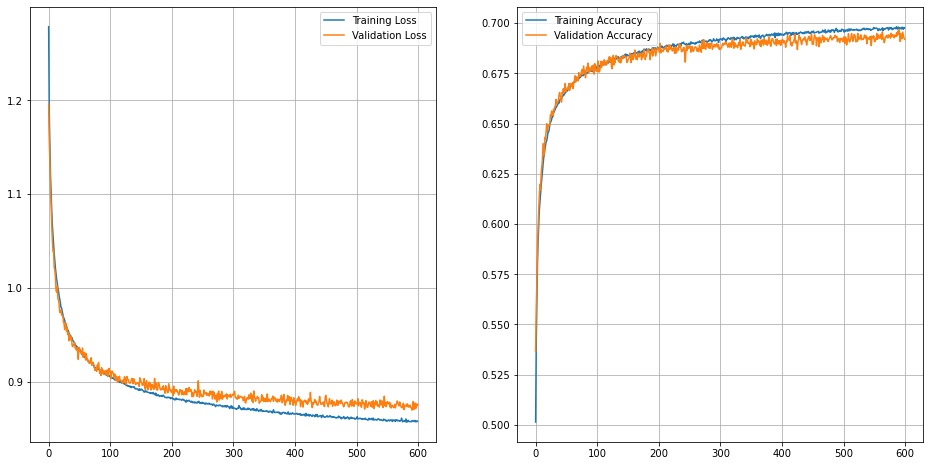

In [14]:
import matplotlib.pyplot as plt

f, a = plt.subplots(ncols = 2, figsize=(16,8))

a[0].plot(history.history['loss'], label = "Training Loss")
a[0].plot(history.history['val_loss'], label = "Validation Loss")

a[0].legend()
a[0].grid(True)

a[1].plot(history.history['sparse_categorical_accuracy'], label = "Training Accuracy")
a[1].plot(history.history['val_sparse_categorical_accuracy'], label = "Validation Accuracy")

a[1].legend()
a[1].grid(True)

We see that the validation curve follows the training one quite well throughout the history, both for the loss function and for the prediction accuracy.
This is partly thanks to the dropout layer, as it can be seen that repeating the training in its absence results in a greater tendency to overfitting.

Let us check "by hand" that the accuracy is as reported in the `history` of the training.

In [15]:
p_vectors = model.predict(X_test)
p_idx     = np.array([np.argmax(v) for v in p_vectors])

In [16]:
t = Y_test.flatten()

In [17]:
np.sum(t == p_idx) / p_idx.size

0.6919312384232932

Now let us test again the model against some unseen data (the June trajectories), and evaluate accuracy.

In [18]:
it_p_vectors = model.predict(X_it)
it_p_idx     = np.array([np.argmax(v) for v in it_p_vectors])
it_p_idx.shape

(382732,)

In [20]:
it_t = Y_it.flatten()
np.sum(it_t == it_p_idx) / it_p_idx.size

0.6859133806423293

We can see that the two accuracies are quite comparable, pointing out reasonable generalisation capabilities of the network.

With this encoding, moreover, we can test explicitly our algorithm against the null model as well, which we see yielding a much lower accuracy of $\approx 12.5 \%$

In [56]:
null_model = np.random.randint(0, 8, size = it_p_idx.shape[0])

In [57]:
np.sum(null_model == it_p_idx) / it_p_idx.size

0.12556566997272242